In [1]:
import os
import os.path as osp
from model_2016 import Net_2016 
import torch
from tqdm import tqdm
import torchvision
from image_functions import *
from dataset_general import CustomDataset
import matplotlib.pyplot as plt

In [2]:
# load best model
root = os.getcwd()
save_dir = osp.join(root, "saved/base_model.pt")
model = Net_2016()
model.load_state_dict(torch.load(save_dir))
model.eval()

# set to gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cpu device


In [35]:
def evaluate(model, datalist, criterion):
    """
    model: The NN to evaluate
    datalist: list of tuple of input, target values
    criterion: loss function

    Retuns: list of len-3 tuples given by (filename: string, outputs: tensor, loss: number)
    """
    model.eval()
    running_loss = 0.0
    running_og_loss = 0.0

    results = []
    for idx, data in enumerate(tqdm(datalist)):
        fn, inputs, labels = data
        print(inputs.shape, labels.shape)

        if inputs.shape[0]==1:
            print("gray")
            inputs = inputs.expand(3, -1, -1)
            labels = inputs.expand(3, -1, -1)
        
        inputs = inputs.to(torch.float)
        labels = labels.to(torch.float)
        inputs = inputs.to(device)
        labels = labels.to(device)

                
        # # Get model outputs and calculate loss
        outputs = model(inputs)
        print(outputs.shape)
        loss = criterion(outputs, labels)
        og_loss = criterion(inputs, labels)

        running_loss += loss
        running_og_loss += og_loss
        print('{} Original Loss: {:.4f}'.format(fn, og_loss))
        print('{} Model Loss: {:.4f}'.format(fn, loss))
        print('Running Loss: {:.4f}'.format(running_loss))

        results.append((fn, outputs, loss))
        
    print('Avg Original Loss: {:.4f}'.format(running_og_loss/len(datalist)))
    print('Avg Model Loss: {:.4f}'.format(running_loss/len(datalist)))
    return results

In [37]:
# directory of images to evaluate
root = os.getcwd()
img_dir = osp.join(root, "data/set14")

factor = 3

read_data = lambda path: torchvision.io.read_image(path) # reads into tensor
transform = lambda img: interpolate(sub_sample(img, factor), factor) # subsample down, interpolate back up
dataset = CustomDataset(img_dir, read_data, transform) # TODO: try different size_lim later
datalist = dataset.getlist()

results = evaluate(model, datalist, nn.functional.mse_loss)

  0%|          | 0/14 [00:00<?, ?it/s]

torch.Size([1, 510, 510]) torch.Size([1, 510, 510])
gray


  7%|▋         | 1/14 [00:00<00:02,  4.49it/s]

torch.Size([3, 510, 510])
img_003_SRF_3_HR.png Original Loss: 0.0000
img_003_SRF_3_HR.png Model Loss: 151.5702
Running Loss: 151.5702
torch.Size([3, 288, 351]) torch.Size([3, 288, 351])
torch.Size([3, 288, 351])
img_008_SRF_3_HR.png Original Loss: 210.4805
img_008_SRF_3_HR.png Model Loss: 189.7756
Running Loss: 341.3458
torch.Size([3, 510, 510]) torch.Size([3, 510, 510])


 21%|██▏       | 3/14 [00:00<00:02,  5.03it/s]

torch.Size([3, 510, 510])
img_010_SRF_3_HR.png Original Loss: 416.0021
img_010_SRF_3_HR.png Model Loss: 310.1902
Running Loss: 651.5360
torch.Size([3, 654, 528]) torch.Size([3, 654, 528])


 29%|██▊       | 4/14 [00:01<00:02,  3.40it/s]

torch.Size([3, 654, 528])
img_013_SRF_3_HR.png Original Loss: 1125.5300
img_013_SRF_3_HR.png Model Loss: 722.2577
Running Loss: 1373.7937
torch.Size([3, 360, 249]) torch.Size([3, 360, 249])
torch.Size([3, 360, 249])
img_005_SRF_3_HR.png Original Loss: 1069.3033
img_005_SRF_3_HR.png Model Loss: 780.6279
Running Loss: 2154.4216
torch.Size([3, 360, 498]) torch.Size([3, 360, 498])


 43%|████▎     | 6/14 [00:01<00:01,  4.74it/s]

torch.Size([3, 360, 498])
img_007_SRF_3_HR.png Original Loss: 480.6912
img_007_SRF_3_HR.png Model Loss: 328.9259
Running Loss: 2483.3477
torch.Size([3, 576, 720]) torch.Size([3, 576, 720])


 50%|█████     | 7/14 [00:01<00:02,  3.24it/s]

torch.Size([3, 576, 720])
img_002_SRF_3_HR.png Original Loss: 461.5954
img_002_SRF_3_HR.png Model Loss: 377.3051
Running Loss: 2860.6528
torch.Size([3, 390, 585]) torch.Size([3, 390, 585])


 64%|██████▍   | 9/14 [00:02<00:01,  4.09it/s]

torch.Size([3, 390, 585])
img_014_SRF_3_HR.png Original Loss: 690.1152
img_014_SRF_3_HR.png Model Loss: 365.6467
Running Loss: 3226.2996
torch.Size([3, 288, 351]) torch.Size([3, 288, 351])
torch.Size([3, 288, 351])
img_004_SRF_3_HR.png Original Loss: 432.4188
img_004_SRF_3_HR.png Model Loss: 332.5096
Running Loss: 3558.8091
torch.Size([3, 510, 510]) torch.Size([3, 510, 510])


 71%|███████▏  | 10/14 [00:02<00:00,  4.01it/s]

torch.Size([3, 510, 510])
img_012_SRF_3_HR.png Original Loss: 237.1287
img_012_SRF_3_HR.png Model Loss: 162.8269
Running Loss: 3721.6360
torch.Size([3, 510, 510]) torch.Size([3, 510, 510])


 79%|███████▊  | 11/14 [00:02<00:00,  4.04it/s]

torch.Size([3, 510, 510])
img_009_SRF_3_HR.png Original Loss: 194.9821
img_009_SRF_3_HR.png Model Loss: 119.2523
Running Loss: 3840.8882
torch.Size([3, 276, 276]) torch.Size([3, 276, 276])
torch.Size([3, 276, 276])
img_006_SRF_3_HR.png Original Loss: 175.0166
img_006_SRF_3_HR.png Model Loss: 123.3182
Running Loss: 3964.2065
torch.Size([3, 480, 498]) torch.Size([3, 480, 498])


 93%|█████████▎| 13/14 [00:03<00:00,  3.59it/s]

torch.Size([3, 480, 498])
img_001_SRF_3_HR.png Original Loss: 975.4493
img_001_SRF_3_HR.png Model Loss: 874.8638
Running Loss: 4839.0703
torch.Size([3, 510, 768]) torch.Size([3, 510, 768])


100%|██████████| 14/14 [00:03<00:00,  3.57it/s]

torch.Size([3, 510, 768])
img_011_SRF_3_HR.png Original Loss: 260.0416
img_011_SRF_3_HR.png Model Loss: 161.0852
Running Loss: 5000.1558
Avg Original Loss: 480.6253
Avg Model Loss: 357.1540


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


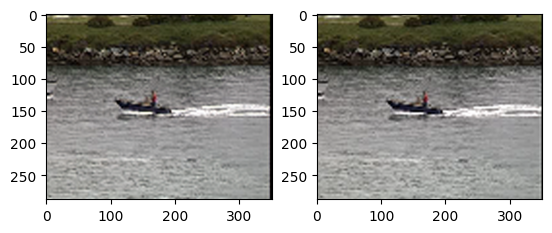

In [31]:
fn, res, loss = results[0]
fn_inp, inp, target = datalist[0]

res = torch.einsum('ijk->jki', res.detach())
res = res.to(torch.int)
plt.subplot(1, 2, 1)
plt.imshow(res)

inp = torch.einsum('ijk->jki', inp.detach())
inp = inp.to(torch.int)
plt.subplot(1, 2, 2)
plt.imshow(inp)
plt.show()
